In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


In [3]:
#baca data CSV
dataset = pd.read_csv('used_cars.csv')
dataset.shape

(20001, 26)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    20001 non-null  int64  
 1   id            20001 non-null  int64  
 2   url           20001 non-null  object 
 3   region        20001 non-null  object 
 4   region_url    20001 non-null  object 
 5   price         20001 non-null  int64  
 6   year          19989 non-null  float64
 7   manufacturer  19296 non-null  object 
 8   model         19736 non-null  object 
 9   condition     10849 non-null  object 
 10  cylinders     12916 non-null  object 
 11  fuel          19928 non-null  object 
 12  odometer      17612 non-null  float64
 13  title_status  19891 non-null  object 
 14  transmission  19811 non-null  object 
 15  vin           13356 non-null  object 
 16  drive         15359 non-null  object 
 17  size          6886 non-null   object 
 18  type          16342 non-nu

In [5]:
#data county sama unnamed:0 harus di drop karena county berisi nan dan unnamed berisi sama dengan id
# di drop karena ketika dimasukkan ke pandas profiling menjadi error
dataset = dataset.drop(['Unnamed: 0','id','county'],1)

# Data Exploration

In [6]:
profile = ProfileReport(dataset, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [7]:
profile

# Data Cleansing 

In [643]:
#drop data-data yang tidak terpakai
dataset_drop = dataset.drop(['size','lat','long','state','vin','image_url'
                             ,'url','fuel','region','region_url','title_status','description'
                             ,'type','transmission','paint_color','model','manufacturer','cylinders','drive'],1).copy()

In [644]:
#ubah data categorical ke dalam bentuk integer
dataset_replace = dataset_drop.copy()
dataset_replace = dataset_replace.replace({'condition' : {'excellent' :6,'new':5,'like new':4,'good':3,'fair':2,'salvage':1}})
dataset_replace['price'] = dataset_replace['price'].replace(0,np.nan)

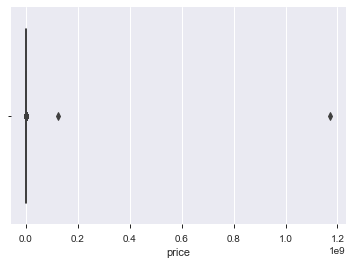

In [645]:
# visualisasi data Outlier
sns.boxplot(x=dataset_replace['price'])

In [646]:
#menghitung quantile 1 dan quantile 3 dan IQR
dataset_outlier = dataset_replace.copy()

Q1 = dataset_outlier.quantile(0.25)
Q3 = dataset_outlier.quantile(0.75)
IQR = Q3 - Q1
#merubah data outlier menjadi nan
mask = (dataset_outlier < (Q1 - 0.5 * IQR)) | (dataset_outlier > (Q3 + 0.5 * IQR))
dataset_outlier[mask] = np.nan

In [647]:
#mengganti data nan menjadi nilai mean
dataset_outlier['year'] = dataset_outlier['year'].fillna(round(dataset_outlier['year'].mean()))
dataset_outlier['odometer'] = dataset_outlier['odometer'].fillna(round(dataset_outlier['odometer'].mean()))
dataset_outlier['condition'] = dataset_outlier['condition'].fillna(round(dataset_outlier['condition'].mean()))

In [648]:
## Check data outlier
((dataset_outlier < (Q1 - 0.5 * IQR)) | (dataset_outlier > (Q3 + 0.5 * IQR))).sum()

price        0
year         0
condition    0
odometer     0
dtype: int64

In [649]:
#check nilai nan yang masih ada
dataset_outlier.isna().sum()

price        4738
year            0
condition       0
odometer        0
dtype: int64

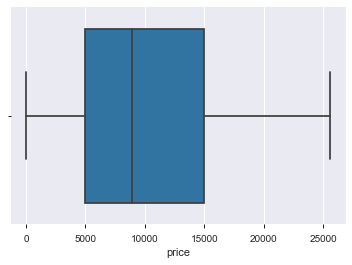

In [650]:
sns.boxplot(x=dataset_clean['price'])

In [651]:
#drop data nan yang tidak bisa diubah menjadi nilai median
dataset_outlier = dataset_outlier.dropna()
dataset_outlier = dataset_outlier.reset_index(drop=True)

In [652]:
dataset_outlier.count()

price        15263
year         15263
condition    15263
odometer     15263
dtype: int64

In [653]:
#ubah data price menjadi 3 kategori
Q1_price = dataset_outlier['price'].quantile(0.25)
Q2_price = dataset_outlier['price'].quantile(0.5)
Q3_price = dataset_outlier['price'].quantile(0.75)

#loop untuk mengubah data ke dalam 3 kategori dan masukkan ke dalam list
pricelist = []
for i in range(len(dataset_outlier)):
    if (dataset_outlier['price'].loc[i] <Q1_price):
        pricelist.append('Bawah')
    elif (dataset_outlier['price'].loc[i] >= Q1_price) and (dataset_outlier['price'].loc[i] < Q2_price):
        pricelist.append('Menengah-Kebawah')
    elif(dataset_outlier['price'].loc[i] >= Q2_price) and (dataset_outlier['price'].loc[i] < Q3_price):
        pricelist.append('Menengah-Keatas')
    else:
        pricelist.append('Atas')

In [654]:
#masukkan data price dari list kedalam dataset kembali
dataset_clean = dataset_outlier.copy()
dataset_clean['grade']=pricelist

In [655]:
#simpan dataset yang sudah bersih ke dalam csv
dataset_clean.to_csv('dataset_clean.csv',index=False)

In [656]:
dataset_clean.groupby('grade').count()

,price,year,condition,odometer
grade,,,,
Atas,3817,3817,3817,3817
Bawah,3803,3803,3803,3803
Menengah-Keatas,3829,3829,3829,3829
Menengah-Kebawah,3814,3814,3814,3814


# Feature Enginering

In [657]:
#pisah data menjadi 2, x sebagai parameter label dan y sebagai label
#data label yang diambil adalah data price
data_train_df_x = dataset_clean.drop(['grade'],1).copy()
data_train_df_y = dataset_clean['grade'].copy()

In [658]:
#ubah data_train_df_x dari DataFrame ke dalam bentuk list
data_train_x = data_train_df_x.values.tolist()
data_train_y = data_train_df_y.values.tolist()

In [659]:
#scaling data menggunakan minmax atau standar scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#data x di scaling menggunakan standard scaler
std_scaler = StandardScaler()
data_x_scale_standard = std_scaler.fit_transform(data_train_x)

#data x di scaling menggunakan standard scaler
mm_scaler = MinMaxScaler()
data_x_minmax = mm_scaler.fit_transform(data_train_x)

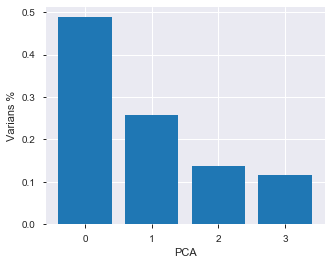

In [660]:
#inisialisasi PCA
pca_std = PCA(4)
pca_std.fit(data_x_scale_standard)
#ubah data_train_x yang sudah di scaling menggunakan standar scaler
principalComponents_std = pd.DataFrame(pca_std.fit_transform(data_x_scale_standard))
num_pca_features = range(pca_std.n_components_)

#plot tingkat varians untuk tiap n PCA
plt.figure(figsize=(5,4))
plt.bar(num_pca_features,pca_std.explained_variance_ratio_)
plt.xlabel('PCA')
plt.ylabel('Varians %')
plt.xticks(num_pca_features)
plt.show()



In [661]:
sum(pca_std.explained_variance_ratio_[0:3])

0.8828529934689335

In [662]:
#masukkan data kembali menjadi DataFrame
dataset_pca_standard = principalComponents_std.iloc[:,:2]
dataset_pca_standard.columns = ['x1','x2']


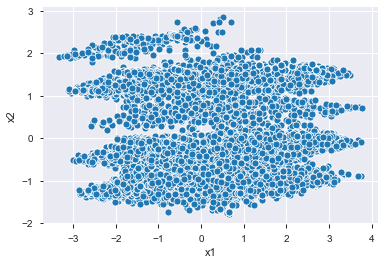

In [663]:
#lihat plot dari dataset yang menggunakan standard scaler
%matplotlib inline 
sns.scatterplot(x='x1',y='x2',data=dataset_pca_standard)

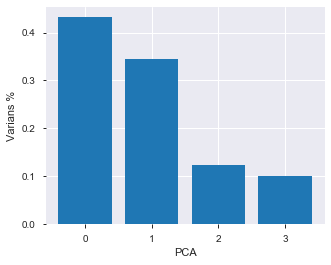

In [664]:
#inisialisasi PCA
pca_mm = PCA(4)

#ubah data_train_x yang sudah di scaling menggunakan min max scaler
principalComponents_mm = pd.DataFrame(pca_mm.fit_transform(data_x_minmax))
num_pca_features = range(pca_mm.n_components_)

#plot tingkat varians untuk tiap n PCA
plt.figure(figsize=(5,4))
plt.bar(num_pca_features,pca_mm.explained_variance_ratio_)
plt.xlabel('PCA')
plt.ylabel('Varians %')
plt.xticks(num_pca_features)
plt.show()


In [665]:
sum(pca_mm.explained_variance_ratio_[0:2])

0.7763707850625634

In [666]:
#masukkan data kembali menjadi DataFrame
dataset_pca_mm = principalComponents_mm.iloc[:,:2]
dataset_pca_mm.columns = ['x1','x2']

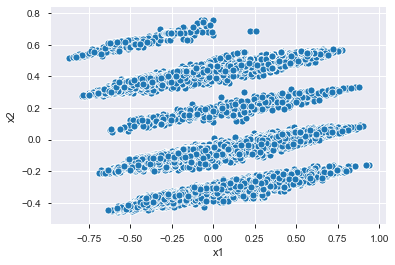

In [667]:
#lihat plot dari dataset yang menggunakan min max scaler
#lihat plot dari dataset yang menggunakan standard scaler
sns.scatterplot(x='x1',y='x2',data=dataset_pca_mm)

In [668]:
#dataset lalu di split untuk digunakan pada saat klasifikasi
from sklearn.model_selection import train_test_split

#dataset di split menjadi 4 bagian
#pada parameter pertama train_test_split dapat menggunakan data_x_minmax atau data_x_scale_standard
x_train, x_test, y_train, y_test = train_test_split(dataset_pca_mm,data_train_y,random_state=5)

# Classification

In [669]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#inisialisasi KNN
clf_knn = KNeighborsClassifier()

#inisialisasi Random Forest
clf_rf = RandomForestClassifier(n_estimators=100,max_depth=None,min_samples_split=2)

#inisialisasi SVM
clf_svm = svm.SVC()

#inisialisasi Neural Network
clf_ann = MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(10,2),random_state=1)

In [670]:
# Train data menggunakan KNN
clf_knn.fit(x_train,y_train)

# Train data menggunakan Random Forest
clf_rf.fit(x_train,y_train)

# Train data menggunakan SVM
clf_svm.fit(x_train,y_train)

# Train data menggunakan Neural Network
clf_ann.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [671]:
#masukkan data hasil akurasi ke dalam DataFrame
classifier_model = pd.DataFrame({'Model':['Nearest Neighbor','Random Forest','SVM','Neural Network'],
                                 'Accuracy':[clf_knn.score(x_test,y_test),clf_rf.score(x_test,y_test),clf_svm.score(x_test,y_test),clf_ann.score(x_test,y_test)]})

In [672]:
#lihat data akurasi setiap model
classifier_model

,Model,Accuracy
0,Nearest Neighbor,0.814203
1,Random Forest,0.863994
2,SVM,0.584906
3,Neural Network,0.243711


In [607]:
##data yang sudah di simpan di csv
klasifikasi_mm = pd.read_csv('model_klasifikasi_min_max.csv')
klasifikasi_mm

,Unnamed: 0,Model,Accuracy
0,0,Nearest Neighbor,0.814203
1,1,Random Forest,0.860849
2,2,SVM,0.584906
3,3,Neural Network,0.243711


In [608]:
klasifikasi_std = pd.read_csv('model_klasifikasi_std.csv')
klasifikasi_std

,Unnamed: 0,Model,Accuracy
0,0,Nearest Neighbor,0.820231
1,1,Random Forest,0.865828
2,2,SVM,0.781447
3,3,Neural Network,0.795073


# Centroid 5

In [222]:
#fungsi untuk menghitung jarak euclidean
def euclideanDistant(row, centroid):
    distance = 0
    for i in range(len(row)):
        distance += (row[i] - centroid[i])**2
        
    return np.sqrt(distance)

#fungsi untuk mendapatkan cluster dari satu data
def getCluster(data, centroids):
    cluster = []
    for i in range(len(data)):
        distances = []
        
        #menghitung jarak data ke setiap centroid lalu dimasukkan ke dalam list
        for j in range(len(centroids)):
            distance = euclideanDistant(data.iloc[i], centroids[j])
            distances.append(distance)
        
        #ambil centroid dengan jarak terdekat ke data
        min_value = min(distances)
        
        #lalu gunakan index dari centroid sebagai cluster
        id_minimum = distances.index(min_value)
        cluster.append(id_minimum)

    return cluster

#fungsi untuk membuat centroid baru
def newCentroids(df, k, cluster):
    data = df.copy()
    data['cluster'] = cluster
    
    #data di kategorikan berdasarkan kluster dan nilainya menggunakan nilai rata-rata
    data = data.groupby('cluster').mean()
    
    #fungsi untuk mengganti centroid yang lama
    new_centroids = []
    for i in range(k):
        new_centroids.append(data.loc[i])
    return new_centroids

#fungsi untuk menghitung nilai sum of square errors
def hitungSSE(data, centroids):
    sse = 0
    for i in range(len(data)):
        distances = []
        
        #hitung jarak data ke semua centroid
        for j in range(len(centroids)):
            distance = euclideanDistant(data.iloc[i], centroids[j])
            distances.append(distance)
            
        #ambil data jarak centroid paling dekat ke data untuk dimasukkan ke perhitungan sse
        min_value = min(distances)
        sse += min_value**2

    return sse

#fungsi untuk melakukan clustering
def kMeans(k, n_iter, dataset):
    data = dataset.copy()
    progressBarr = widgets.IntProgress(min=0,max=n_iter,description='Iterasi')
    display(progressBarr)

    #centroid awal diambil dari data yang sudah ada di dataset
    centroids = data.sample(k,random_state=5).values.tolist()
    
    for i in range(n_iter):
        
        cluster = getCluster(data, centroids)
        
        centroids = newCentroids(data, k, cluster)
        
        progressBarr.value +=1
        progressBarr.description = 'K-'+ str(progressBar.value+2) + ' Iterasi ' + str(progressBarr.value)
        
    sse = hitungSSE(data, centroids)
    return cluster, sse

# Main Program

In [694]:
#k adalah data berisi jumlah centroid yang akan dipakai
k = [2,3,4,5,6,7,8,9]

In [695]:
#persiapkan 2 list untuk menyimpan data sse dan labels untuk scaling yang menggunakan standard scaler
sse_data_std =[]
labels_data_std = []

In [696]:
import ipywidgets as widgets

#digunakan untuk memperliatkan sudah sampai mana proses trainingnya
progressBar = widgets.IntProgress(min=0,max=len(k),description='K ke-2')
display(progressBar)

#melakukan pengulangan untuk setiap centroid di data k
for i in range(len(k)):
    
    #panggil fungsi clustering 
    labels,sse = kMeans(k[i],20,dataset_pca_standard)
    
    #masukkan data labels ke dalam list
    labels_data_std.append(labels)
    
    #masukkan data sse ke dalam list
    sse_data_std.append(sse)
    
    #fungsi untuk mengubah display sejauh mana proses trainingnya
    progressBar.value +=1
    progressBar.description = 'K ke- ' + str(progressBar.value + 2)

IntProgress(value=0, description='K ke-2', max=8)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

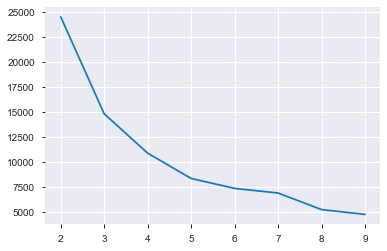

In [697]:
#visualisasi Elbow Method
sns.lineplot(y=sse_data_std,x=k)

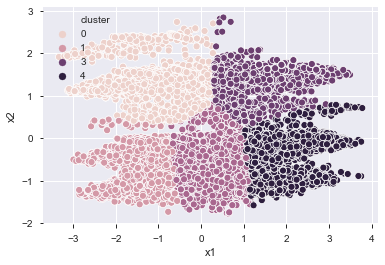

In [698]:
#visualisasi cluster dan dataset
df_viz_std = dataset_pca_standard.copy()
df_viz_std['cluster'] = labels_data_std[3]
sns.scatterplot(x='x1', y='x2', hue='cluster', data=df_viz_std)

In [699]:
#persiapkan 2 list untuk menyimpan data sse dan labels untuk scaling yang menggunakan min max scaler

sse_data_mm =[]
labels_data_mm = []

In [700]:
import ipywidgets as widgets

#digunakan untuk memperliatkan sudah sampai mana proses trainingnya
progressBar = widgets.IntProgress(min=0,max=len(k),description='K Ke-2')
display(progressBar)

#melakukan pengulangan untuk setiap centroid di data k
for i in range(len(k)):
    
    #panggil fungsi clustering 
    labels,sse = kMeans(k[i],20,dataset_pca_mm)
    
    #masukkan data labels ke dalam list
    labels_data_mm.append(labels)
    
    #masukkan data sse ke dalam list
    sse_data_mm.append(sse)
    
    #fungsi untuk mengubah display sejauh mana proses trainingnya
    progressBar.value +=1
    progressBar.description = 'K Ke- ' + str(progressBar.value + 2)

IntProgress(value=0, description='K Ke-2', max=8)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

IntProgress(value=0, description='Iterasi', max=20)

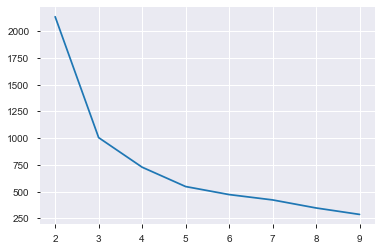

In [701]:
#Visualisasi Elbow Method
sns.lineplot(y=sse_data_mm,x=k)

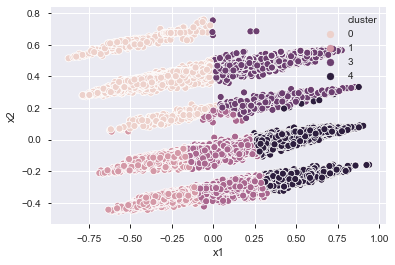

In [702]:
#visualisasi cluster dan dataset
df_viz_mm = dataset_pca_mm.copy()
df_viz_mm['cluster'] = labels_data_mm[3]
%matplotlib inline
sns.scatterplot(x='x1',y='x2',hue='cluster',data=df_viz_mm)

In [718]:
## Evaluasi
dataset_cluster_std = dataset_clean.copy()
dataset_cluster_std['cluster'] = labels_data_std[3]
dataset_cluster_mm = dataset_clean.copy()
dataset_cluster_mm['cluster'] = labels_data_mm[3]

In [717]:
#save data label atau cluster dan sse
labels_mm_save = pd.DataFrame(labels_data_mm)
labels_std_save = pd.DataFrame(labels_data_std)
sse_mm_save = pd.DataFrame(sse_data_mm)
sse_std_save = pd.DataFrame(sse_data_std)

labels_mm_save.to_csv('labels_mm.csv',index=False)
labels_std_save.to_csv('labels_std.csv',index=False)
sse_mm_save.to_csv('sse_mm.csv',index=False)
sse_std_save.to_csv('sse_std.csv',index=False)

In [720]:
#analisis std
for i in range(5):
    print(i)
    data_analysis = dataset_cluster_std[dataset_cluster_std['cluster']== i]
    print(data_analysis.grade.value_counts(),'\n')

0
Bawah               1592
Menengah-Kebawah     929
Menengah-Keatas      412
Atas                  85
Name: grade, dtype: int64 

1
Bawah               1617
Menengah-Kebawah    1486
Menengah-Keatas      469
Atas                  69
Name: grade, dtype: int64 

2
Menengah-Keatas     1811
Menengah-Kebawah    1292
Atas                 872
Bawah                561
Name: grade, dtype: int64 

3
Atas                851
Menengah-Keatas     466
Menengah-Kebawah     77
Bawah                32
Name: grade, dtype: int64 

4
Atas                1940
Menengah-Keatas      671
Menengah-Kebawah      30
Bawah                  1
Name: grade, dtype: int64 



In [721]:
#analisis std
for i in range(5):
    print(i)
    data_analysis = dataset_cluster_mm[dataset_cluster_mm['cluster']== i]
    print(data_analysis.grade.value_counts(),'\n')

0
Bawah               1616
Menengah-Kebawah     972
Menengah-Keatas      423
Atas                  75
Name: grade, dtype: int64 

1
Bawah               1663
Menengah-Kebawah    1500
Menengah-Keatas      421
Atas                  45
Name: grade, dtype: int64 

2
Menengah-Keatas     1827
Menengah-Kebawah    1262
Atas                 771
Bawah                504
Name: grade, dtype: int64 

3
Atas                930
Menengah-Keatas     481
Menengah-Kebawah     57
Bawah                19
Name: grade, dtype: int64 

4
Atas                1996
Menengah-Keatas      677
Menengah-Kebawah      23
Bawah                  1
Name: grade, dtype: int64 

